In [1]:
#run only once!
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from Schuster_Resonators.approx_Schuster import *
from CPW.cpw import *
import scipy.io as sc
import scipy.signal as sig

# 12pHsq

In [15]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240422-12Res-12pH'
file_list = os.listdir(path)
print(file_list)
d_12 = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_12[name] = {'freq': freq, 'amp': amp}

['12pH_first_test.mat', 'feedline_thicker_3p5_8p5-v1.mat', 'feedline_ticker.mat', 'FirstRes-12ph-v3.mat', 'FirstRes12pH.mat', 'FistRes12pHsq-v1.mat', 'LastRes-12pHsq-v1.mat', 'LastRes12pH.mat', 'S21_bondpad_fix.mat', 'Z21_bondpad_fix.mat', 'ZIN1_bondpad_fix.mat', 'ZIN2_bondpad_fix.mat']


(3.5, 8.5)

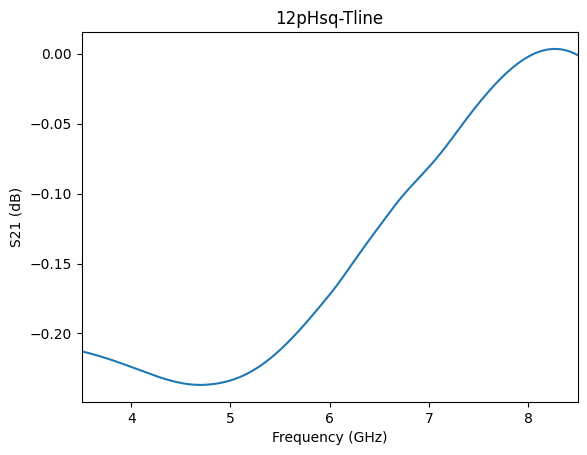

In [16]:
plt.plot(d_12['feedline_thicker_3p5_8p5-v1']['freq']*1e-9,d_12['feedline_thicker_3p5_8p5-v1']['amp'])
plt.title('12pHsq-Tline')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(3.5, 8.5)

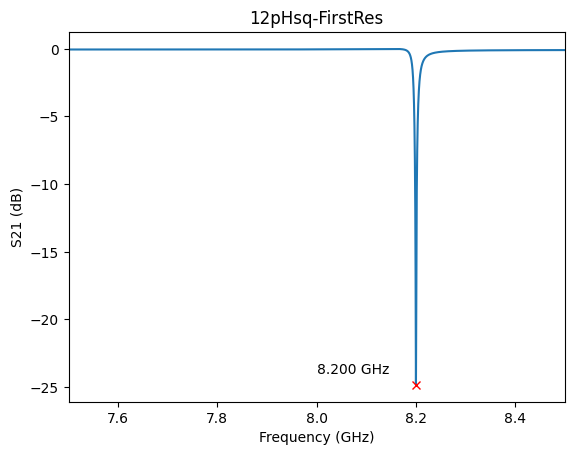

In [17]:
plt.plot(d_12['FistRes12pHsq-v1']['freq']*1e-9,d_12['FistRes12pHsq-v1']['amp'])
plt.title('12pHsq-FirstRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(7.5, 8.5)
peak, _ = sig.find_peaks(-d_12['FistRes12pHsq-v1']['amp'], prominence = 0.1)
f0 = d_12['FistRes12pHsq-v1']['freq'][peak[0]]
plt.text(8, -24, f'{f0*1e-9:.3f} GHz')
plt.plot(d_12['FistRes12pHsq-v1']['freq'][peak[0]]*1e-9,d_12['FistRes12pHsq-v1']['amp'][peak[0]], 'rx')

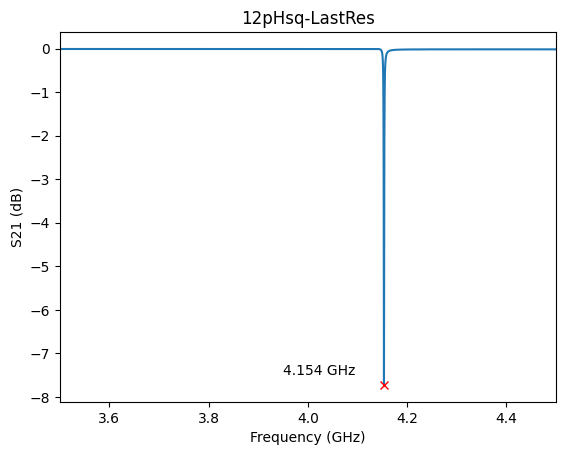

In [18]:
plt.plot(d_12['LastRes-12pHsq-v1']['freq']*1e-9,d_12['LastRes-12pHsq-v1']['amp'])
plt.title('12pHsq-LastRes')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S21 (dB)')
plt.xlim(3.5, 4.5)
peak, _ = sig.find_peaks(-d_12['LastRes-12pHsq-v1']['amp'], prominence = 0.1)
f0 = d_12['LastRes-12pHsq-v1']['freq'][peak[0]]
plt.text(3.95, -7.5, f'{f0*1e-9:.3f} GHz')
plt.plot(d_12['LastRes-12pHsq-v1']['freq'][peak[0]]*1e-9,d_12['LastRes-12pHsq-v1']['amp'][peak[0]], 'rx')




# 24pHsq

In [4]:
path = r'C:\Users\localadmin\Documents\GitHub\resonators\mat_files\20240610-SiRes-24pHsq-v1'
file_list = os.listdir(path)
print(file_list)
d_24 = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    amp = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_24[name] = {'freq': freq, 'amp': amp}
    

['24pHsq-FirstRes.mat', '24pHsq-LastRes.mat', '24pHsq-Tline.mat']


Text(0.5, 1.0, '24pHsq-Tline')

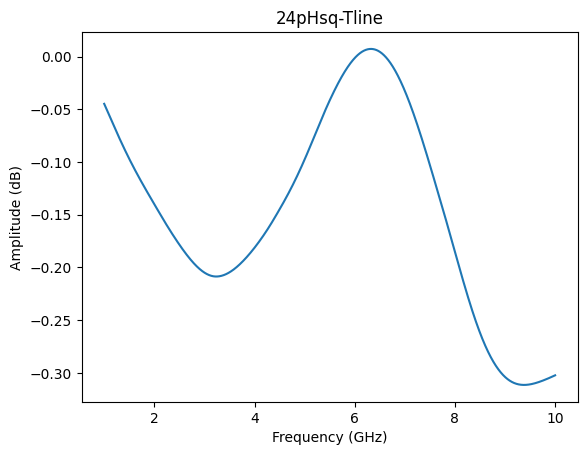

In [8]:
plt.plot(1e-9*d_24['24pHsq-Tline']['freq'], d_24['24pHsq-Tline']['amp'])
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-Tline')

Text(0.5, 1.0, '24pHsq-FirstRes')

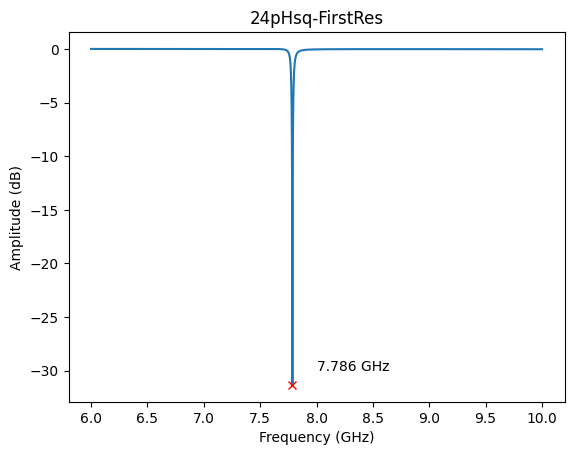

In [10]:
plt.plot(1e-9*d_24['24pHsq-FirstRes']['freq'], d_24['24pHsq-FirstRes']['amp'])
peak, _ = sig.find_peaks(-d_24['24pHsq-FirstRes']['amp'], prominence = 0.1)
f0 = d_24['24pHsq-FirstRes']['freq'][peak[0]]
plt.text(8, -30, f'{f0*1e-9:.3f} GHz')
plt.plot(d_24['24pHsq-FirstRes']['freq'][peak[0]]*1e-9,d_24['24pHsq-FirstRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-FirstRes')

Text(0.5, 1.0, '24pHsq-LastRes')

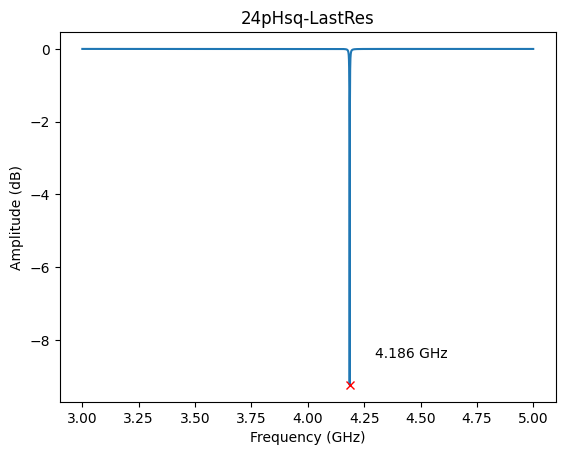

In [13]:
plt.plot(1e-9*d_24['24pHsq-LastRes']['freq'], d_24['24pHsq-LastRes']['amp'])
peak, _ = sig.find_peaks(-d_24['24pHsq-LastRes']['amp'], prominence = 0.1)
f0 = d_24['24pHsq-LastRes']['freq'][peak[0]]
plt.text(4.3, -8.5, f'{f0*1e-9:.3f} GHz')
plt.plot(d_24['24pHsq-LastRes']['freq'][peak[0]]*1e-9,d_24['24pHsq-LastRes']['amp'][peak[0]], 'rx')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dB)')
plt.title('24pHsq-LastRes')